Based on: https://www.samsonzhang.com/2020/11/24/understanding-the-math-behind-neural-networks-by-building-one-from-scratch-no-tf-keras-just-numpy

In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt

def load_data():
    # with open('samples/t10k-images.idx3-ubyte','rb') as f:
    with open('samples/train-images.idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, -1))
        data=data/255
    # with open('samples/t10k-labels.idx1-ubyte','rb') as f:
    with open('samples/train-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        labels = labels.reshape((size,)) # (Optional)
    return labels, data, nrows, ncols

def load_validation_data():
    with open('samples/t10k-images.idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, -1))
        data=data/255
    with open('samples/t10k-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        labels = labels.reshape((size,)) # (Optional)
    return labels, data, nrows, ncols


In [2]:
def ReLU(Z):
    return np.maximum(Z,0)

def ReLU_dev(Z):
    return 1*(Z>0)

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z),axis=0)
    return A

def forward_prop(W1,b1,W2,b2,X):
    Z1=W1.dot(X)+b1
    A1=ReLU(Z1)
    Z2=W2.dot(A1)+b2
    A2=softmax(Z2)
    return Z1,A1,Z2,A2

def get_predictions(A2):
    return np.argmax(A2,axis=0)

In [3]:
def one_hot(y,max=None):
    if max==None:
        max=y.max()
    yy=np.zeros((max+1,y.size))
    yy[y,np.arange(y.size)]=1
    return yy

In [4]:
def cross_ent(y,y_hat): # true(onehotencoded), predicted
    return -np.log(y_hat.T[y.astype(bool).T])

In [5]:
def init_params():
    N_L1=100
    N_L2=10
    W1 = np.random.rand(N_L1, 784) - 0.5
    b1 = np.random.rand(N_L1, 1) - 0.5
    W2 = np.random.rand(N_L2, N_L1) - 0.5
    b2 = np.random.rand(N_L2, 1) - 0.5
    return W1, b1, W2, b2

In [6]:
# forward_prop(W1,b1,W2,b2,X):
# return Z1,A1,Z2,A2
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y,Y_max=None):
    N=Y.size
    one_hot_y=one_hot(Y,Y_max)
    dZ2=A2-one_hot_y
    db2=np.sum(dZ2,axis=1,keepdims=True)/N
    dW2=dZ2.dot(A1.T)/N
    dZ1=W2.T.dot(dZ2)*ReLU_dev(Z1)
    db1=np.sum(dZ1,axis=1,keepdims=True)/N
    dW1=dZ1.dot(X.T)/N
    return dW1,db1,dW2,db2

In [7]:
def update_params(W1,b1, W2,b2,dW1,db1,dW2,db2,alpha):
    W1-=dW1*alpha
    b1-=db1*alpha
    W2-=dW2*alpha
    b2-=db2*alpha
    return W1, b1, W2, b2

In [8]:
def get_accuracy(predictions,Y):
    return np.sum(predictions==Y)/Y.size

In [9]:
def batch_split(x,batch_size,axis):
    b=batch_size
    x=x.swapaxes(0,axis)
    l=x.shape[0]
    n_b=range(l//b)
    for r in n_b:
        yield x[r*b:(r+1)*b].swapaxes(0,axis)
    if l%b>0:
        yield x[l//b*b:].swapaxes(0,axis)


In [10]:
def gradient_descent(X,Y,alpha,epochs,batch_size=100,X_v=None,Y_v=None):
    W1, b1, W2, b2 =init_params()
    N=Y.size
    Y_max=Y.max()
    debug=[]
    for i in range(epochs):
        # Shuffle trainig data first
        perms=np.random.permutation(N)
        X=X[:,perms]
        Y=Y[perms]
        # Split in batches and run every batch each epoch. 
        for X_b,Y_b in zip(batch_split(X,batch_size,axis=1),batch_split(Y,batch_size,axis=0)):
            Z1,A1,Z2,A2 = forward_prop(W1,b1,W2,b2,X_b)
            dW1,db1,dW2,db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_b, Y_b,Y_max)
            W1, b1, W2, b2 = update_params(W1,b1, W2,b2,dW1,db1,dW2,db2,alpha)

        if i%1==0 or i==epochs-1:
            _,_,_,A2 = forward_prop(W1,b1,W2,b2,X)
            predictions=get_predictions(A2)
            acc=get_accuracy(predictions,Y)
            acc_v=0
            if X_v is not None and Y_v is not None:
                _,_,_,A2_v = forward_prop(W1,b1,W2,b2,X_v)
                predictions_v=get_predictions(A2_v)
                acc_v=get_accuracy(predictions_v,Y_v)
            debug.append((i,acc,acc_v))
            print(f"Epoch: {i}\t\tAccuracy: {acc:.4f} \t\tAccuracy_v: {acc_v:.4f}")

    return W1,b1,W2,b2,debug

In [15]:
labels_train, data_train, nrows,ncols =load_data()
data_train=data_train.T
labels_validation, data_validation, _,_ =load_validation_data()
data_validation=data_validation.T
W1,b1,W2,b2,debug=gradient_descent(data_train,labels_train,0.1,100,batch_size=100,X_v=data_validation,Y_v=labels_validation)

Epoch: 0		Accuracy: 0.9053 		Accuracy_v: 0.9035
Epoch: 1		Accuracy: 0.9262 		Accuracy_v: 0.9210
Epoch: 2		Accuracy: 0.9379 		Accuracy_v: 0.9327
Epoch: 3		Accuracy: 0.9451 		Accuracy_v: 0.9424
Epoch: 4		Accuracy: 0.9477 		Accuracy_v: 0.9445
Epoch: 5		Accuracy: 0.9538 		Accuracy_v: 0.9492
Epoch: 6		Accuracy: 0.9577 		Accuracy_v: 0.9517
Epoch: 7		Accuracy: 0.9610 		Accuracy_v: 0.9527
Epoch: 8		Accuracy: 0.9630 		Accuracy_v: 0.9545
Epoch: 9		Accuracy: 0.9675 		Accuracy_v: 0.9581
Epoch: 10		Accuracy: 0.9688 		Accuracy_v: 0.9581
Epoch: 11		Accuracy: 0.9695 		Accuracy_v: 0.9600
Epoch: 12		Accuracy: 0.9710 		Accuracy_v: 0.9613
Epoch: 13		Accuracy: 0.9721 		Accuracy_v: 0.9621
Epoch: 14		Accuracy: 0.9748 		Accuracy_v: 0.9630
Epoch: 15		Accuracy: 0.9756 		Accuracy_v: 0.9639
Epoch: 16		Accuracy: 0.9760 		Accuracy_v: 0.9640
Epoch: 17		Accuracy: 0.9768 		Accuracy_v: 0.9640
Epoch: 18		Accuracy: 0.9795 		Accuracy_v: 0.9666
Epoch: 19		Accuracy: 0.9768 		Accuracy_v: 0.9628
Epoch: 20		Accuracy: 0.9809 		

Final accuracy (Using training data):	 0.9998333333333334
Final accuracy (Using validation data):	 0.9713


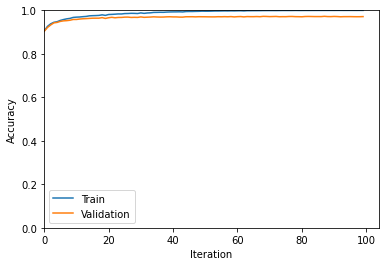

In [16]:
x,y1,y2=zip(*debug)
plt.plot(x,y1)
plt.plot(x,y2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
ax = plt.gca()
ax.set_xlim([0, None])
ax.set_ylim([0, 1])
print("Final accuracy (Using training data):\t",y1[-1])
print("Final accuracy (Using validation data):\t",y2[-1])
ax.legend(["Train","Validation"])
plt.show()

# Accuracy checks with training data

In [17]:
_,_,_,A2=forward_prop(W1,b1,W2,b2,data_train)
predictions_train=get_predictions(A2)
acc=get_accuracy(predictions_train,labels_train)

correct=labels_train==predictions_train

print("Accuracy: ",acc)
print("Mislabeled: ", np.sum(~correct))
print("ID\tLabel\tPrediction\tError")
for i,(lab,pred,right) in enumerate(zip(*(labels_train,predictions_train,correct))):
    if not right:
        print(f"{i}\t{lab}\t\t{pred}\t {'x' if not right else ''}")
        pass


Accuracy:  0.9998333333333334
Mislabeled:  10
ID	Label	Prediction	Error
6885	1		8	 x
11949	3		8	 x
21601	1		6	 x
34404	9		8	 x
37816	1		4	 x
37834	7		1	 x
42566	9		4	 x
43109	8		1	 x
51248	9		4	 x
59915	4		7	 x


Label: 9	Prediction: 4


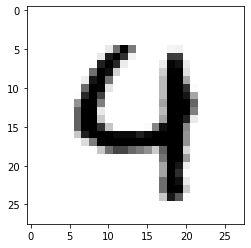

In [21]:
n=51248	
plt.imshow(data_train[:,n].reshape(nrows,ncols), cmap='gray_r')
print(f"Label: {labels_train[n]}\tPrediction: {predictions_train[n]}")
plt.show()

# Accuracy checks with validation data

In [19]:
_,_,_,A2=forward_prop(W1,b1,W2,b2,data_validation)
predictions_validation=get_predictions(A2)
acc=get_accuracy(predictions_validation,labels_validation)

correct=labels_validation==predictions_validation

print("Accuracy: ",acc)
print("Mislabeled: ", np.sum(~correct))
print("ID\tLabel\tPrediction\tError")
for i,(lab,pred,right) in enumerate(zip(*(labels_validation,predictions_validation,correct))):
    if not right:
        print(f"{i}\t{lab}\t\t{pred}\t {'x' if not right else ''}")
        pass


Accuracy:  0.9713
Mislabeled:  287
ID	Label	Prediction	Error
61	8		2	 x
124	7		4	 x
193	9		7	 x
247	4		2	 x
259	6		0	 x
321	2		7	 x
326	2		1	 x
340	5		3	 x
406	5		9	 x
445	6		0	 x
449	3		5	 x
495	8		0	 x
528	3		2	 x
578	3		2	 x
583	2		7	 x
619	1		8	 x
629	2		6	 x
646	2		6	 x
658	7		4	 x
659	2		1	 x
684	7		3	 x
691	8		4	 x
720	5		8	 x
786	6		5	 x
846	7		9	 x
939	2		0	 x
947	8		9	 x
951	5		4	 x
956	1		2	 x
965	6		0	 x
999	9		7	 x
1014	6		5	 x
1039	7		1	 x
1112	4		6	 x
1138	2		1	 x
1156	7		8	 x
1181	6		1	 x
1226	7		2	 x
1242	4		9	 x
1247	9		5	 x
1260	7		1	 x
1299	5		7	 x
1311	9		7	 x
1319	8		3	 x
1328	7		9	 x
1364	8		2	 x
1393	5		3	 x
1444	6		9	 x
1447	5		6	 x
1464	8		3	 x
1500	7		1	 x
1522	7		9	 x
1530	8		7	 x
1549	4		6	 x
1553	9		8	 x
1609	2		6	 x
1621	0		6	 x
1670	5		3	 x
1671	7		3	 x
1681	3		7	 x
1686	8		3	 x
1790	2		8	 x
1800	6		2	 x
1813	8		0	 x
1901	9		4	 x
1909	1		7	 x
1941	7		9	 x
1952	9		8	 x
1969	6		0	 x
1973	8		3	 x
1982	6		5	 x
1987	0		9	 x
2004	8		3	 x
2016	7		2	 x
2043	4		8

Label: 2	Prediction: 8


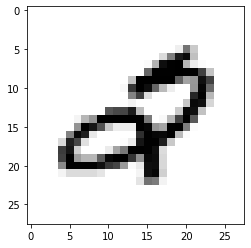

In [26]:
n=9904
plt.imshow(data_validation[:,n].reshape(nrows,ncols), cmap='gray_r')
print(f"Label: {labels_validation[n]}\tPrediction: {predictions_validation[n]}")
plt.show()

-------------------